# Anomaly Detection with Isolation Forest

This notebook demonstrates how using a sliding window technique improves the ability of Isolation Forest to detect anomalies in time-series data.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Load dataset
df = pd.read_csv("data/ec2_cpu_utilization.csv")
df['timestamp'] = pd.to_datetime(df['timestamp'])
df['label'] = 0
known_anomalies = ["2014-02-26 22:05:00","2014-02-27 17:15:00"]
df.loc[df['timestamp'].isin(pd.to_datetime(known_anomalies)), 'label'] = 1

print(f"Total data points: {len(df)}, Known anomalies: {df['label'].sum()}")
df.head()

Total data points: 4032, Known anomalies: 2


,timestamp,value,label
0,2014-02-14 14:30:00,0.132,0
1,2014-02-14 14:35:00,0.134,0
2,2014-02-14 14:40:00,0.134,0
3,2014-02-14 14:45:00,0.134,0
4,2014-02-14 14:50:00,0.134,0


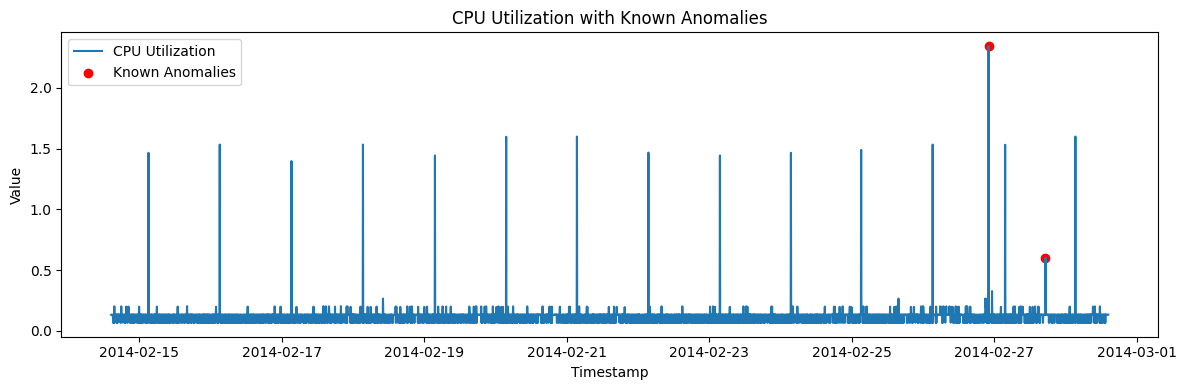

In [2]:
# Plot raw data with known anomalies
plt.figure(figsize=(12, 4))
plt.plot(df['timestamp'], df['value'], label='CPU Utilization')
plt.scatter(df[df['label'] == 1]['timestamp'], df[df['label'] == 1]['value'], color='red', label='Known Anomalies')
plt.title('CPU Utilization with Known Anomalies')
plt.xlabel('Timestamp')
plt.ylabel('Value')
plt.legend()
plt.tight_layout()
plt.show()

#### 1. Train Isolation Forest on raw values

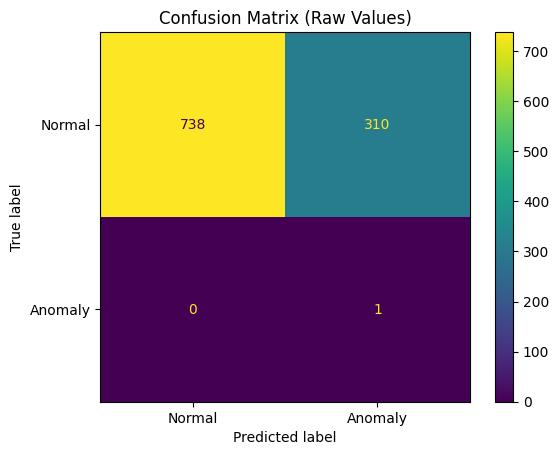

In [40]:
X = df[['value']]
y = df['label'].replace({0: 1, 1: -1}).values  # for compatibility with IsolationForest

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.26, random_state=42, stratify=y)
model_raw = IsolationForest(n_estimators=150, contamination='auto', random_state=42)
model_raw.fit(X_train)
preds_raw = model_raw.predict(X_test)

# Confusion matrix for raw values
cm_raw = confusion_matrix(y_test, preds_raw, labels=[1, -1])
ConfusionMatrixDisplay(confusion_matrix=cm_raw, display_labels=['Normal', 'Anomaly']).plot()
plt.title("Confusion Matrix (Raw Values)")
plt.grid(False)
plt.show()

#### 2. Train Isolation forest using sliding window features

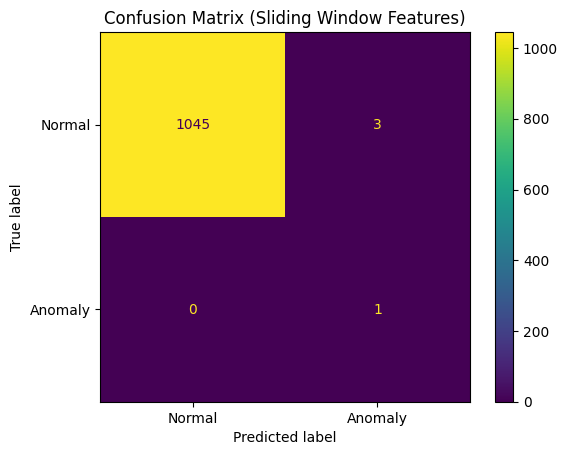

In [39]:
window_size = 15
X_window = np.array([
    np.pad(df['value'].iloc[max(0, i - window_size + 1):i + 1].values,
           (window_size - min(i + 1, window_size), 0),
           mode='constant', constant_values=np.nan)
    for i in range(len(df))
])
imputer = SimpleImputer(strategy='most_frequent')
X_window_imputed = imputer.fit_transform(X_window)
y_window = df['label'].replace({0: 1, 1: -1}).values

# Train-test split for sliding window
X_train_win, X_test_win, y_train_win, y_test_win = train_test_split(
    X_window_imputed, y_window, test_size=0.26, random_state=42, stratify=y_window
)
model_window = IsolationForest(n_estimators=150, contamination='auto', random_state=42)
model_window.fit(X_train_win)
preds_window = model_window.predict(X_test_win)

# Confusion matrix
cm_window = confusion_matrix(y_test_win, preds_window, labels=[1, -1])
ConfusionMatrixDisplay(confusion_matrix=cm_window, display_labels=['Normal', 'Anomaly']).plot()
plt.title("Confusion Matrix (Sliding Window Features)")
plt.grid(False)
plt.show()

#### Summary:

In first method, model has misclassified 310 normal values as anomalies, which is quite high. But in sliding window approach, it has shown better results.

After implementing above methods we can conclude that a sliding window approach, transforms time series into short sequences that can better capture local patterns and helps improve the inferencing accurracy.